In [ ]:
import cusfbamboo as bam
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI
import cantera as ct

First run: assuming high chamber pressure, high O/F, and high combustion temperature

In [ ]:
'''Chosen operating points'''
# O/F = 5.0
pc = 2.7579e6           # Chamber pressure (Pa)
_pc = 2.7579e6

'''From ProPEP 3 I got the following data on my exhaust gas'''
gamma = 1.262               # Ratio of specific heats cp/cv 
molecular_weight = 21.368   # Molecular weight of the exhaust gas (kg/kmol) 
Tc = 2768.943               # Chamber temperature (K)

In [ ]:
perfect_gas = bam.PerfectGas(gamma = gamma, molecular_weight = molecular_weight)
chamber_conditions = bam.ChamberConditions(p0 = pc, T0 = Tc)

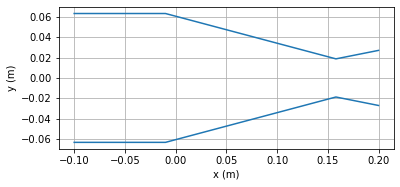

Sea level thrust = 4.275495962102911 kN
Sea level Isp = 223.7293317749996 s

Throat pressure = 15.24263906351112 bar
Throat temperature = 2448.2254641909817 K
Throat Mach number = 1.0

Exit pressure = 2.874044846945594 bar
Exit temperature = 1731.5152740397655 K
Exit Mach number = 2.1386027159955496
1.9480251867079972


In [ ]:
xs = [-0.1, -0.08, -0.025, -0.01, 0.158, 0.2]         # The values in 'xs' must be in increasing order
rs = [0.127/2, 0.127/2, 0.127/2, 0.127/2, 0.0376/2, 0.02715]
geometry = bam.Geometry(xs = xs, rs = rs)

engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry)
engine.plot()
bam.show()

print(f"Sea level thrust = {engine.thrust(p_amb = 1e5)/1000} kN")
print(f"Sea level Isp = {engine.isp(p_amb = 1e5)/9.81} s")

print(f"\nThroat pressure = {engine.p(x = geometry.x_t)/1e5} bar")
print(f"Throat temperature = {engine.T(x = geometry.x_t)} K")
print(f"Throat Mach number = {engine.M(x = geometry.x_t)}")

print(f"\nExit pressure = {engine.p(xs[-1])/1e5} bar")
print(f"Exit temperature = {engine.T(xs[-1])} K")
print(f"Exit Mach number = {engine.M(xs[-1])}")

print(engine.mdot)

In [ ]:
gas = ct.Solution('gri30.yaml')
# We set up an exhaust gas model using Cantera - using the exhaust gas properties we found before
# Then we set up the coolant transport properties with CoolProp

# Setup the exhaust gas transport properties using Cantera
def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number (from bamboo Cantera example)

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

# Set up the coolant transport properties using Cantera
# defining coolant:
coolant = ct.Solution('gri30.yaml')
gas.TPY = 298.15, _pc, "N2O:1" # defining starting conditions for coolant to be at chamber pressure and standard ambient temperature

P = 5.24e6

coolant_name = "NITROUSOXIDE"
def Pr_coolant(T, p):
    coolant.TP = T, p
    return PropsSI('PRANDTL','P', P,'Q',0, 'WATER')

def mu_coolant(T, p):
    coolant.TP = T, p
    return PropsSI('V','P', P,'Q',0, coolant_name)

def k_coolant(T, p):
    coolant.TP = T, p
    return PropsSI('L','P', P,'Q',0, coolant_name)

def cp_coolant(T, p):
    coolant.TP = T, p
    return PropsSI('C','P', P,'Q',0, coolant_name)

def rho_coolant(T, p):
    coolant.TP = T, p
    return PropsSI('D','P', P,'Q',0, coolant_name)

k = 17.4
cp = PropsSI('C','P', P,'Q',0, coolant_name)
mu = 3.237e-03

coolant_transport = bam.TransportProperties(Pr = (cp * mu)/k,
                                            mu = 3.237e-03,
                                            k = k,
                                            cp = PropsSI('C','P', P,'Q',0, coolant_name),
                                            rho = PropsSI('D','P', P,'Q',0, coolant_name))

# Note: when using CoolProp for coolant trasnport properties, get following error
# ValueError: Viscosity model is not available for this fluid : 
# PropsSI("PRANDTL","T",298.15,"P",2758000,"NITROUSOXIDE")
# so using Cantera instead

'''Cooling jacket properties'''
inlet_T = 298.15                           # Coolant inlet static temperature (K)
inlet_p = 5.171e6                             # Coolant inlet static pressure (bar)
OF_ratio = 5                             # Oxidiser/fuel mass ratio
mdot_coolant = engine.mdot/(OF_ratio + 1)  # Mass flow rate of coolant

x = np.linspace(5e-4, 10e-3, 10)
y = np.linspace(5e-4, 10e-3, 10)

'''Add a spiral cooling jacket to the engine'''
# See the documentation for a full list of cooling jacket options

#cooling_jacket = bam.CoolingJacket(T_coolant_in = inlet_T, 
#                                  p_coolant_in = inlet_p, 
 #                                 mdot_coolant = mdot_coolant, 
  #                                channel_height = x,
   #                               channel_width = y,
    #                              blockage_ratio = 0.3,
     #                             restrain_fins = True,
      #                            coolant_transport = coolant_transport,
       #                           configuration = 'spiral')#, number_of_channels = 50)

'Add a spiral cooling jacket to the engine'

In [ ]:
copper = bam.Material(E = 117e9, poisson = 0.34, alpha = 16.9e-6, k = 391.2)
stainless_steel = bam.Material(E = 193e9, poisson = 0.29, alpha = 16e-6, k = 14.0)

def variable_thickness(x):
    fraction = (x - xs[0]) / (xs[-1] - xs[0])
    return 4e-3 * (1 - fraction) + 1e-3

inner_wall = bam.Wall(material = copper, thickness = 5e-3)
#outer_wall = bam.Wall(material = copper, thickness = 2e-3)   # Thickness that decreases with increasing x

In [8]:
for x_val in x:
    for y_val in y:
        # Create a cooling jacket instance for each combination of x_val and y_val
        cooling_jacket = bam.CoolingJacket(
            T_coolant_in=inlet_T, 
            p_coolant_in=inlet_p, 
            mdot_coolant=mdot_coolant, 
            channel_height=x_val,
            channel_width=y_val,
            blockage_ratio=0.3,
            restrain_fins=True,
            coolant_transport=coolant_transport,
            configuration='vertical', number_of_channels = 50)

        engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    exhaust_transport = exhaust_transport,
                    cooling_jacket = cooling_jacket,
                    walls = [inner_wall],
                    coolant_convection = "gnielinski",
                    exhaust_convection = "bartz-sigma")
        
        cooling_data = engine.steady_heating_analysis()
        if cooling_data['T_coolant'][-1] < 310:
            engine.plot()
            bam.plot.plot_temperatures(cooling_data)
            bam.show()
            print(f"\nCoolant exit temperature: {cooling_data['T_coolant'][-1]} K")
            # Print of the keys so we can see what data is available
            print("")
            print(cooling_data.keys())

# We can get information on what each key means, with the 'info' key.
            print("\nInformation on the 'T' key:")
            print(cooling_data["info"]["T"])

C:\Users\lukas\anaconda3\lib\site-packages\cusfbamboo\hx.py:84: UserWarning: ReDh < 2300 in cooling channels: Laminar flow relations will be used. Constant wall temperature is assumed for Nusselt number.
  R = self.Rdx(self.state[i]))


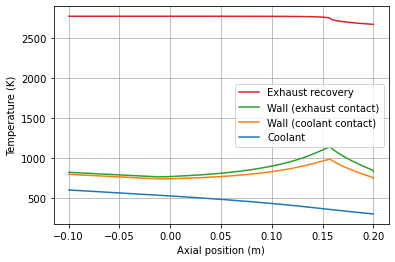

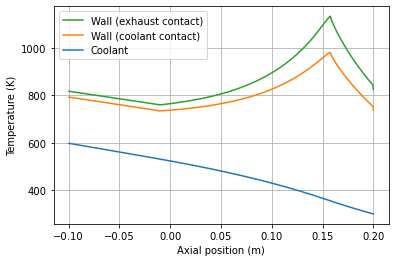

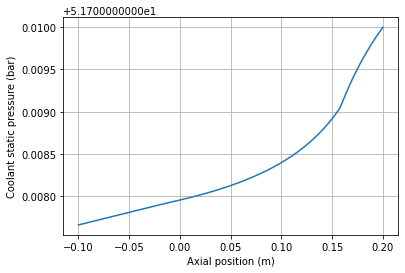

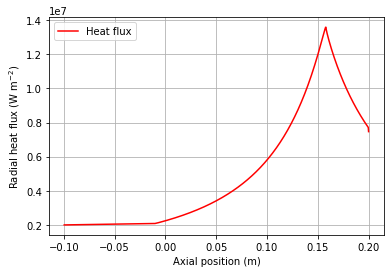

In [8]:
bam.plot.plot_temperatures(cooling_data)
bam.show()

bam.plot.plot_temperatures(cooling_data, only_indexes = [0,1,2])   # Exclude the exhaust gas temperature from the plot
bam.show()

bam.plot.plot_p_coolant(cooling_data)
bam.show()

bam.plot.plot_q_per_area(cooling_data)
bam.show()